In [2]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jieba
jieba.set_dictionary('dict.txt.big')
stopwords = [ line.rstrip() for line in open('stop_words.txt' , encoding='utf8') ] # if you want to use you should modify it yourself
    
from pprint import pprint
import requests
import json


# for treining
import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

import xgboost as xgb
from pylab import rcParams

from datetime import datetime
import string

## get crawled data from local mongoDB
## if you don't want to implement crawling part, you can ignore it
# def getall(col_name):
#     conn = MongoClient()
#     db = conn.QA1999
#     collection = db[col_name]
#     cursor = collection.find({})
#     rows = [row for row in cursor]
#     df = pd.DataFrame(rows)
#     return df
# df_train = getall('hsinchu')
# with open('RawData.json', 'w', encoding='utf8') as f:
#     data = list(df_train[['id', 'question', 'ans', 'cat']].T.to_dict().values())
#     json.dump(data, f, ensure_ascii=False)

# This is crawled from 新竹社會局常見問答集
def getall():
    with open('RawData.json', 'r', encoding='utf8') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    return df



c:\users\jeremy\appdata\local\programs\python\python35\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data Description

In [2]:
## crawled data may not have words and vector columns, and the id is categoryid
df_train = getall()
df_train.head()

,ans,cat,id,question
0,1.幼兒家長在戶政事務所完成新生兒出生登記後，即可向所轄區公所社政課提出育兒津貼申請。2.在...,幼兒福利及托育服務,189,小孩出生後應於何時申請育兒津貼?
1,隨時提出;津貼經審查通過後，追溯自受理申請之當月起發給。兒童出生後六十日內向戶政事務所完成出...,幼兒福利及托育服務,189,小孩出生後應於何時申請育兒津貼?
2,申請資料應備齊:(一)兒童之戶口名簿影本。(二)申請人之郵局存摺封面影本。(三)父母雙方身分...,幼兒福利及托育服務,189,育兒津貼申請應備文件為何?
3,一、育兒津貼補助對象：1.育有二足歲以下兒童。2.兒童之父母至少一方因育兒需要，致未能就業者...,幼兒福利及托育服務,189,若民眾夫妻雙方均失業，是否可申請家庭育兒津貼費用補助
4,育兒津貼補助對象，應符合下列規定：(一)育有二足歲以下兒童。(二)兒童之父母(或監護人)至少...,幼兒福利及托育服務,189,育兒津貼補助對象為何？


In [3]:
print("Rows=", len(df_train))

Rows= 327


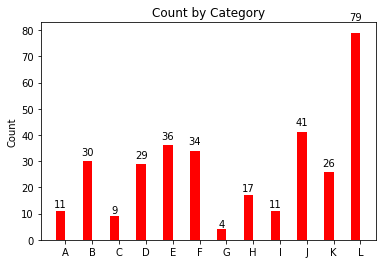

A 人民團體及合作社場服務 11
B 兒童少年及家庭福利 30
C 國民年金 9
D 婦女福利 29
E 家庭暴力及性侵害防治服務 36
F 幼兒福利及托育服務 34
G 志願服務 4
H 社區發展服務 17
I 社工專業服務 11
J 社會救助 41
K 老人福利 26
L 身心障礙者福利 79


In [4]:
df_train = getall()
# getall('taipei')
main_series = df_train.groupby('cat').count()['ans']

N = len(main_series)
means = list(main_series)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, means, width, color='r')

# add some text for labels, title and axes ticks
ax.set_ylabel('Count')
ax.set_title('Count by Category')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels("ABCDEFGHIJKLMNOPQRSTU")


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)

plt.show()

for i in range(len(list(main_series.index))):
    label = 'ABCDEFGHIJKLMNOPQRSTU'
    print(label[i], main_series.index[i], list(main_series)[i])

### Explaination:
due the unbalanced distribution, we have to balance data first

In [5]:
from wordcloud import WordCloud
from collections import Counter

freqs = []
for cat in list(set(df_train['cat'])):
    words_Li = list(df_train[df_train['cat'] == cat]['words'])
    total_words_in_cat = []
    for words in words_Li:
        total_words_in_cat.extend(words)
    freq = Counter(total_words_in_cat)
    freqs.append(freq)

KeyError: 'words'

In [6]:
# wordcloud = WordCloud()
# wordcloud.generate_from_frequencies(frequencies=freqs[0])
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

NameError: name 'wordcloud' is not defined

# training preparation 

In [5]:
# transfer sentence into words
def preprocess(row):
    words = list(jieba.cut(row['question'], cut_all=False)) ## cut sentences into words
    row['words'] = words
    return row
df_train = df_train.apply(preprocess, axis=1)

Building prefix dict from D:\Projects\hsinchu_QA1999_ClassifierTraining\dict.txt.big ...
Loading model from cache C:\Users\Jeremy\AppData\Local\Temp\jieba.u906c0974c994a6001383593a1370395c.cache
Loading model cost 1.533 seconds.
Prefix dict has been built succesfully.


In [6]:
# for training requirement, you have to prepare numerical category. As a result we map the text category into 1 ~ 11
cat_mapping = {}
for num, cat in enumerate(list(set(df_train['cat']))):
    cat_mapping[cat] = num

In [7]:
# due to the consistency of training and prediction preprocess, we have to recore the category 
with open('cat_mapping', 'w', encoding='utf8') as f:
    json.dump(cat_mapping, f, ensure_ascii=False)

In [8]:
# save into json data
with open('ProcessedData.json', 'w', encoding='utf8') as f:
    data = list(df_train.T.to_dict().values())
    json.dump(data, f, ensure_ascii=False)

# Start Classify

In [3]:
def getprocessed():
    with open('ProcessedData.json', 'r', encoding='utf8') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    return df

with open('cat_mapping', 'r' , encoding='utf8') as f:
    cat_mapping = json.load(f)
    
df_train = getprocessed()
df_train.head()

,ans,cat,id,question,words
0,1.幼兒家長在戶政事務所完成新生兒出生登記後，即可向所轄區公所社政課提出育兒津貼申請。2.在...,幼兒福利及托育服務,189,小孩出生後應於何時申請育兒津貼?,"[小孩, 出生, 後, 應於, 何時, 申請, 育兒, 津貼, ?]"
1,隨時提出;津貼經審查通過後，追溯自受理申請之當月起發給。兒童出生後六十日內向戶政事務所完成出...,幼兒福利及托育服務,189,小孩出生後應於何時申請育兒津貼?,"[小孩, 出生, 後, 應於, 何時, 申請, 育兒, 津貼, ?]"
2,申請資料應備齊:(一)兒童之戶口名簿影本。(二)申請人之郵局存摺封面影本。(三)父母雙方身分...,幼兒福利及托育服務,189,育兒津貼申請應備文件為何?,"[育兒, 津貼, 申請, 應備, 文件, 為何, ?]"
3,一、育兒津貼補助對象：1.育有二足歲以下兒童。2.兒童之父母至少一方因育兒需要，致未能就業者...,幼兒福利及托育服務,189,若民眾夫妻雙方均失業，是否可申請家庭育兒津貼費用補助,"[若民眾, 夫妻, 雙方, 均, 失業, ，, 是否, 可, 申請, 家庭, 育兒, 津貼,..."
4,育兒津貼補助對象，應符合下列規定：(一)育有二足歲以下兒童。(二)兒童之父母(或監護人)至少...,幼兒福利及托育服務,189,育兒津貼補助對象為何？,"[育兒, 津貼, 補助, 對象, 為何, ？]"


In [4]:
print('Preprocess Length = ', len(df_train))

# add category itself as question to process question with only few words
addedrow = []
for key, value in cat_mapping.items():
    row = {}
    words = list(jieba.cut(key, cut_all=False))
    row['words'] = words
    
    row = {'ans': None,
            'cat': key,
            'cat_num': value,
            'id': None,
            'question': key,
            'words':words
          }
    addedrow.append(row)
addeddf = pd.DataFrame(addedrow)
df_train = pd.concat([df_train, addeddf])
print('Processed Length = ', len(df_train))

Building prefix dict from D:\Projects\hsinchu_QA1999_ClassifierTraining\dict.txt.big ...
Loading model from cache C:\Users\Jeremy\AppData\Local\Temp\jieba.u906c0974c994a6001383593a1370395c.cache


Preprocess Length =  327


Loading model cost 2.678 seconds.
Prefix dict has been built succesfully.


Processed Length =  339


In [6]:
# prepare a consistent-ordered term list
total_li = []
for li in list(df_train['words']):
    total_li += li
vectorterms = list(set(total_li))

## map every question into vector
def process_into_vector(row):
    self_main_list = [0] * len(vectorterms)
    for term in row['words']:
        idx = vectorterms.index(term)
        self_main_list[idx] += 1
    row['vector'] = self_main_list
    row['cat_num'] = cat_mapping.get(row['cat'])
    return row
df_train = df_train.apply(process_into_vector, axis=1)
df_train.index = range(len(df_train))

In [7]:
# due to the consistency of training and prediction preprocess, we have to recore the word od the dimension in a vector
with open('vectorterms_nonword2vec', 'w', encoding='utf8') as f:
    json.dump(vectorterms, f, ensure_ascii=False)

In [8]:
df_train.head()

,ans,cat,cat_num,id,question,words,vector
0,1.幼兒家長在戶政事務所完成新生兒出生登記後，即可向所轄區公所社政課提出育兒津貼申請。2.在...,幼兒福利及托育服務,10,189,小孩出生後應於何時申請育兒津貼?,"[小孩, 出生, 後, 應於, 何時, 申請, 育兒, 津貼, ?]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,隨時提出;津貼經審查通過後，追溯自受理申請之當月起發給。兒童出生後六十日內向戶政事務所完成出...,幼兒福利及托育服務,10,189,小孩出生後應於何時申請育兒津貼?,"[小孩, 出生, 後, 應於, 何時, 申請, 育兒, 津貼, ?]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,申請資料應備齊:(一)兒童之戶口名簿影本。(二)申請人之郵局存摺封面影本。(三)父母雙方身分...,幼兒福利及托育服務,10,189,育兒津貼申請應備文件為何?,"[育兒, 津貼, 申請, 應備, 文件, 為何, ?]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,一、育兒津貼補助對象：1.育有二足歲以下兒童。2.兒童之父母至少一方因育兒需要，致未能就業者...,幼兒福利及托育服務,10,189,若民眾夫妻雙方均失業，是否可申請家庭育兒津貼費用補助,"[若民眾, 夫妻, 雙方, 均, 失業, ，, 是否, 可, 申請, 家庭, 育兒, 津貼,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,育兒津貼補助對象，應符合下列規定：(一)育有二足歲以下兒童。(二)兒童之父母(或監護人)至少...,幼兒福利及托育服務,10,189,育兒津貼補助對象為何？,"[育兒, 津貼, 補助, 對象, 為何, ？]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [9]:
print('Preprocess Length = ', len(df_train))

# Rebalance: duplicate row with small-sized category
avg_rows_each_category = len(df_train)/len(cat_mapping)
print("avg_rows_each_category: ", avg_rows_each_category)
for cat in set(df_train['cat']):
    df_reduplicate = df_train[df_train['cat'] == cat]
    while len(df_reduplicate) < avg_rows_each_category:
        idxs = np.random.choice(df_reduplicate.index, size=int(len(df_reduplicate)*0.5))
        df_train = pd.concat([df_train, df_reduplicate.loc(idxs).obj.copy()])
        df_reduplicate = df_train[df_train['cat'] == cat]

print('Processed Length = ', len(df_train))

Preprocess Length =  339
avg_rows_each_category:  28.25
Processed Length =  521


In [10]:
# prepare input for sklearn
X = np.array(list(df_train['vector']))
Y = np.array(df_train['cat_num'])
print(X.shape)
print(Y.shape)

(521, 860)
(521,)


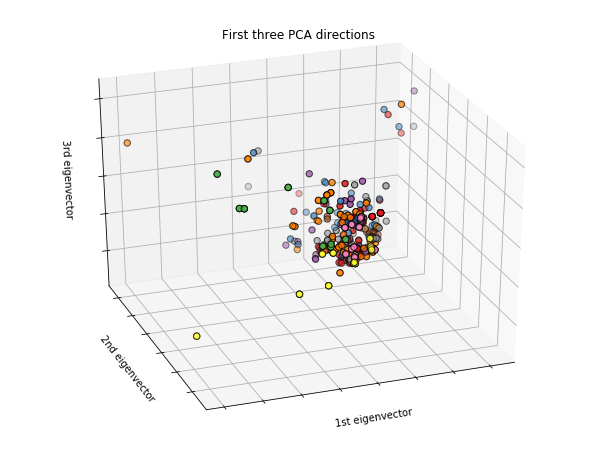

In [11]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

X_reduced = PCA(n_components=3).fit_transform(X)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

### Explaination:
This illustrate that some dimension can have relative high value(that is, the words exist lots of times), if you want to imporve the model later, you may remove the stop words from each sentence

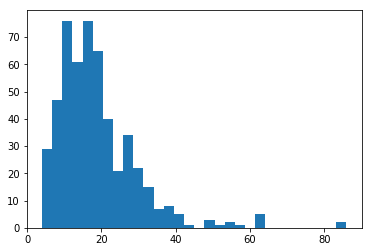

In [12]:
sentence_length = [len(sen) for sen in df_train['question']]
plt.hist(sentence_length, bins=30)
plt.show()

In [13]:
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X, Y) 
y_pred = neigh.predict(X)
print("Number of mislabeled points out of a total %d points : %d" % (X.shape[0],(Y != y_pred).sum()))

Number of mislabeled points out of a total 521 points : 140


In [14]:
clf = SVC(C=2)
clf.fit(X, Y)

y_pred = clf.predict(X)
print("Number of mislabeled points out of a total %d points : %d" % (X.shape[0],(Y != y_pred).sum()))

Number of mislabeled points out of a total 521 points : 421


# XGB

In [15]:
# Finally, we split some of the data off for validation
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(X, Y, test_size=0.2, random_state=4242)

print(x_train_split.shape)
print(x_valid_split.shape)
print(y_train_split.shape)
print(y_valid_split.shape)

(416, 860)
(105, 860)
(416,)
(105,)


In [16]:
# Set our parameters for xgboost
params = {}
params['objective'] = 'multi:softmax'
# scale weight of positive examples
params['eta'] = 0.1
params['max_depth'] = 4
params['silent'] = 1
params['nthread'] = 3
params['num_class'] = len(set(Y))

## control over-fitting, higher depth specific to a particular sample.
d_train = xgb.DMatrix(x_train_split, label=y_train_split)
d_valid = xgb.DMatrix(x_valid_split, label=y_valid_split)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=100, verbose_eval=10)

[0]	train-merror:0.084135	valid-merror:0.171429
Multiple eval metrics have been passed: 'valid-merror' will be used for early stopping.

Will train until valid-merror hasn't improved in 100 rounds.
[10]	train-merror:0.040865	valid-merror:0.142857
[20]	train-merror:0.036058	valid-merror:0.152381
[30]	train-merror:0.024038	valid-merror:0.133333
[40]	train-merror:0.019231	valid-merror:0.114286
[50]	train-merror:0.012019	valid-merror:0.12381
[60]	train-merror:0.012019	valid-merror:0.104762
[70]	train-merror:0.012019	valid-merror:0.095238
[80]	train-merror:0.007212	valid-merror:0.095238
[90]	train-merror:0.007212	valid-merror:0.095238
[100]	train-merror:0.007212	valid-merror:0.095238
[110]	train-merror:0.004808	valid-merror:0.095238
[120]	train-merror:0.004808	valid-merror:0.095238
[130]	train-merror:0.002404	valid-merror:0.095238
[140]	train-merror:0.002404	valid-merror:0.095238
[150]	train-merror:0.002404	valid-merror:0.095238
[160]	train-merror:0.002404	valid-merror:0.085714
[170]	train-

In [17]:
y_pred = bst.predict(xgb.DMatrix(X))
print("Number of mislabeled points out of a total %d points : %d" % (X.shape[0],(Y != y_pred).sum()))

Number of mislabeled points out of a total 521 points : 10


In [18]:
idxs = np.where((Y != y_pred) == True)
cat_mapping_reverse = {}

for key, value in cat_mapping.items():
    cat_mapping_reverse[value] = key
df_train['pred'] = [cat_mapping_reverse.get(int(y)) for y in y_pred]

print("False classified: ")
df_train.loc[idxs[0]][['question', 'cat', 'pred']]

False classified: 


,question,cat,pred
43,如果發現兒童有失依、虐待或疏忽照顧之情形如何處理、通報?,兒童少年及家庭福利,社工專業服務
46,什麼是國外出養?和國內出養有什麼不同?,兒童少年及家庭福利,社區發展服務
51,離婚後孩子監護權歸我，還需要前夫的同意才能出養孩子嗎？,兒童少年及家庭福利,婦女福利
52,什麼是出養?,兒童少年及家庭福利,社區發展服務
65,請問免費法律諮詢及心理諮商服務項目?服務地點?服務時間?申請資格?申請方式?,婦女福利,幼兒福利及托育服務
70,如果外籍配偶或大陸配偶，與丈夫離婚，台灣身份證會失效嗎？,婦女福利,社會救助
119,請問人工電子耳耗材補助申請資格?申請方式?補助金額?,身心障礙者福利,老人福利
191,早期療育在做什麼?,身心障礙者福利,社區發展服務
234,為什麼要做微型保險?,社會救助,社區發展服務
244,"我是男生,有些家庭問題不好啟齒可以找誰幫忙?",家庭暴力及性侵害防治服務,兒童少年及家庭福利


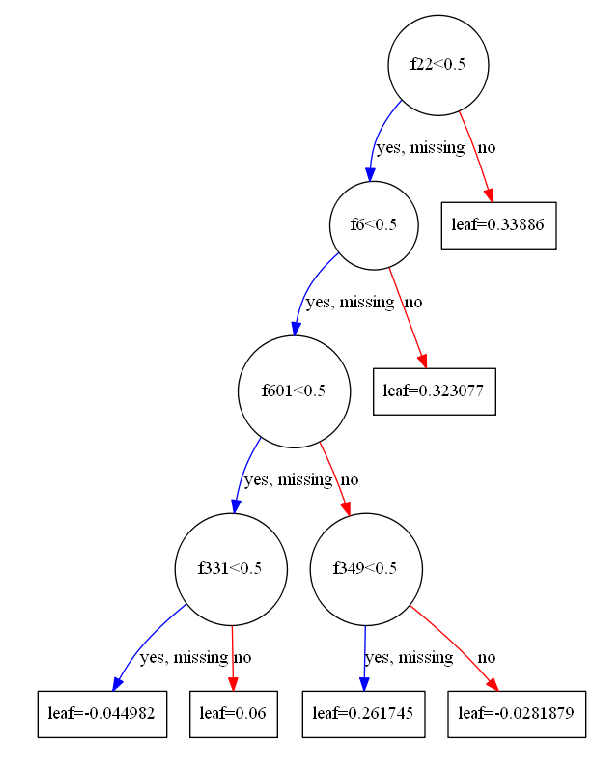

In [19]:
# to visualize the decision tree you can use this
# However it required graviz, which is difficult to install
rcParams['figure.figsize'] = 10, 20

xgb.plot_tree(bst, num_trees=2)
plt.show()

In [20]:
# save trained models
now_time = str(datetime.now())
for pun in string.punctuation:
    now_time = now_time.replace(pun, '')
bst.save_model(now_time+'.model') 

# Application

In [21]:
import jieba
jieba.set_dictionary('dict.txt.big')

import pandas as pd
import requests
import xgboost as xgb
import json
import numpy as np


# This is crawled from 台北社會局常見問答集
testing_questions = ['身心障礙者如無法於效期屆滿前申請或完成重新鑑定及需求評估應如何辦理？', '領有身心障礙證明(手冊)後，如有戶籍異動、證明(手冊)遺失或破損不堪使用、姓名或身分證統一編號變更等情形，如何辦理？', '持有重大傷病證明卡者可否申請身心障礙證明(手冊)？', '我想要收養一個小孩，不知道要去哪裡申請？', '要如何申請危機家庭兒童及少年委託安置暨收容費用補助？\r\n', '發現有迷童、棄嬰或查無身分之兒少，需緊急安置者。', '發現有兒童及少年(含發展遲緩或身心障礙者)無父母或父母失聯，需緊急送醫者。\r\n', '老人健保補助之補助對象、補助額度、申請恢復補助之相關規定為何？', '長青學苑報名資格、上課地點及洽詢單位', '長者預防走失手鍊及身心障礙者防走失手鍊有何不同？', '外籍配偶可否申請「馬上關懷急難救助」？', '「馬上關懷急難救助」有無限制申請次數？', '如何取得「馬上關懷急難救助作業要點」之內容及申請表件？', '「馬上關懷急難救助」向居住所在地或戶籍所在地申請？', '「馬上關懷急難救助」是否僅有低收入戶或非低收入戶才能提出申請？', '「馬上關懷」與本市急難救助有何異同？', '事故發生後何時可以申請「馬上關懷急難救助」？', '馬上關懷急難救助的服務對象?', '「馬上關懷急難救助」經申請（或通報）後，何時可獲得協助？', '「馬上關懷」的申請（或通報）窗口為何？', '申請敬老、愛心及愛心陪伴悠遊卡應備文件為何？ \r\n', '106年度重陽禮金的致送對象?', '免費點數可以用到YouBike或臺北市觀光雙層巴士嗎?', '若想了解自己(未收到通知單)是不是有被社會局補助老人健保費，是不是要自己打電話問?\r\n', '臺北市老人健保自付額補助若發現仍未補助怎麼辦？\r\n', '敬老、愛心及愛心陪伴悠遊卡應該到哪裡辦裡加值?', '我是居留在臺北市的外籍人士，並且已經馬偕計畫審核通過，取得經註記「國內大眾運輸工具及公立育樂場所優待字樣」之外僑永久居留證，請問該如何申請臺北市敬老悠遊卡？\r\n', '從哪裡可以得到老人福利服務資訊？\r\n', '請問二代健保上路後會影響我的老人健保自付額補助資格嗎？', '如果想查詢敬老、愛心悠遊卡每月免費點數或票卡內自行加值之金額該如何查詢(含欲查詢是否有扣款錯誤之情形)？', '我的投保單位(特別是公司)如果已經倒閉以致無法取得老人健保自付額之繳費證明應該怎麼辦?(或是其他種種特殊原因以致無法向原投保單位取得繳費證明亦是，如被資遣或解僱.....)\r\n', '敬老、愛心及愛心陪伴悠遊卡是否也適用悠遊卡小額消費服務？', '臺北市老人健保有補助，為什麼我或者我的子女還在繳費?\r\n', '敬老、愛心悠遊卡有使用期限嗎?', '敬老、愛心及愛心陪伴悠遊卡，遺失該怎麼辦？應備何文件重新辦理？', '申請台北卡-敬老、愛心乘車證服務(原敬老、愛心及愛心陪伴悠遊卡)資格為何？敬老悠遊卡年滿 65 歲當月可以提早申請嗎?受理申請單位為何？', '敬老、愛心及愛心陪伴悠遊卡，故障應備何文件重新辦理？', '敬老、愛心悠遊卡可以借人使用嗎？', '我已遷出臺北市，想要退卡片裡面餘額，要怎麼辦呢？', '搭乘臺北市敬老愛心車隊，是否享有乘車優惠？', '若臺北市政府補貼優惠額度用完，搭乘敬老愛心車隊時，敬老（一）或愛心（一）悠遊卡片會如何扣款？', '10/29之後，敬老卡擴大使用範圍為何？', '什麼時候可以開始用敬老卡免費搭捷運?', '申請(含遺失補發)敬老、愛心及愛心陪伴悠遊卡需多久時間才能領到卡片？若已申請辦好了，在領取時，可否委託人代領？', '如何搭乘臺北市敬老愛心車隊之計程車？', '申請特殊境遇家庭扶助應具備什麼條件？', '申請特殊境遇家庭扶助到收到社會局公文回覆審查結果需要多久時間？', '申請特殊境遇家庭扶助時應檢附哪些文件？', '什麼是特殊境遇家庭扶助？', '特殊境遇家庭之全家人口計算範圍為何？', '我已經是低收入戶，還可以申請特殊境遇家庭扶助嗎？', '特殊境遇家庭扶助的扶助項目有哪些？', '特殊境遇家庭扶助緊急生活補助最多可以補助多少元？', '我之前已申請過特殊境遇家庭緊急生活扶助，是否可再申請1次？', '特殊境遇家庭兒童就托臺北市市立幼兒園有無補助？', '特殊境遇家庭兒童托育津貼如何申請？', '特殊境遇家庭法律訴訟補助對象為何？補助金額多少？', '特殊境遇傷病醫療補助補助對象及補助金額為何？', '特殊境遇家庭扶助申請應備文件之全戶財稅資料要向哪裡申請？成年子女可代為申請嗎？可以由社會局查調嗎？', '特殊境遇家庭扶助申請表格要去哪裡索取？或下載申請表格？', '特殊境遇家庭扶助要向哪個單位申請、申請方式？', '特殊境遇家庭子女教育補助如何申請？', '特殊境遇家庭創業貸款補助為何？要向哪個單位提出申請？', '我是離婚單親，與前配偶共同監護1名4歲小孩，可否申請特殊境遇家庭扶助？', '若敬老（一）或愛心（一）悠遊卡片儲值金額不足，搭乘敬老愛心車隊可以享有市政府補貼優惠嗎？', '月初持敬老悠遊卡至捷運站查詢機查詢每月免費點數，但點數顯示為O，為什麼？', '未成年之兒童、少年、身心障礙少年,遭遺棄虐待、未受適當養育照顧(如長期未進食)或父母生病、入獄等,需緊急安置者', '發現有兒童及少年(含發展遲緩或身心障礙者)遭遺棄、虐待、未受適當養育照顧(如長期未進食、獨自生活、流浪)、或父母(或其他主要照顧者)生病、入獄等，需緊急安置者。', '我想要捐贈金錢或物資給育幼院，請問可以捐給哪些單位？', '申請居家服務資格條件為何?', '石頭湯（社區整合照顧服務）目前共有哪幾區提供服務？', '申請失能者生活輔助器具及居家無障礙環境改善補助應備文件為何？', '本市有哪些老人日間照顧中心(只收失智失能長者，週一至周五白天送至中心照顧) \r\n', '疑似患精神疾病、身心障礙或失智的老人於街上遊蕩而無人照顧。\r\n', '老人緊急救援系統內容為何，如何申請？\r\n', '如何申請使用老人日間照顧服務(至日間照顧中心收托)?', '中低收入戶老人住屋修繕補助如何申請?', '如何查詢臺北市老人福利機構名單及床位狀況?', '長者預防走失手鍊是否有GPS功能?', '申請愛心餐券對象為何？', '領取愛心餐券地點及使用方式為何？', '申請長者預防走失手鍊服務資格？\r\n申請長者預防走失手鍊需檢附的資料？', '我最近看到臺北扶老.軟硬兼施廣告，請問那是什麼服務?怎樣的對象可以申請?', '銀髮友善好站洽詢單位為何？', '身心障礙者專用停車位識別證新制服務對象為何？', '身心障礙者專用停車位識別證新制辦理方式及洽辦單位。', '身心障礙者專用停車位識別證新制上路，領有身心障礙手冊，未經新制身心障礙鑑定，原持有之專用停車位識別證是否有效？', '身心障礙者專用停車位識別證新制上路，領有身心障礙手冊，還能申請專用停車位識別證嗎？', '身心障礙者專用停車位識別證新制申請應備文件。', '「行動不便身心障礙者」之標準為何？', '「行動不便身心障礙者」判定、評估結果及異議處理方式為何？', '101年7月11日起身心障礙者專用停車位識別證新制上路！請說明新制的轉變。', '身心障礙者承租停車位補助的申請資格有哪些?', '身心障礙承租停車位補助金額如何計算?', '身心障礙者承租停車位補助有何查核機制?', '辦理身心障礙者承租停車位租金補助的車輛種類？', '申請身心障礙者承租停車位租金的聯絡窗口?', '已享有本市停管處停車月票優惠者，可否再領取身心障礙者承租停車位補助？', '身心障礙者購買停車位貸款利息補貼的申請資格有哪些?', '身心障礙者購買停車位貸款利息補貼金額如何計算?']

In [25]:
bst = xgb.Booster({'nthread': 4})  # init model
bst.load_model('20171127 125648530042.model')  # load data, you may have to read which model you saved

with open('cat_mapping', 'r' , encoding='utf8') as f:
    cat_mapping = json.load(f)

with open('vectorterms_nonword2vec', 'r' , encoding='utf8') as f:
    vectorterms = json.load(f)
    
def predict_cat(test_sentence):
    print(test_sentence)
    words = list(jieba.cut(test_sentence, cut_all=False))
    print(", ".join(words))
    
    self_main_list = [0] * len(vectorterms)
    for term in words:
        if term in vectorterms:
            idx = vectorterms.index(term)
            self_main_list[idx] += 1
        
    vector = self_main_list
    cat_num = bst.predict(xgb.DMatrix(np.array([vector,])))[0]
    print(cat_num)
    
    cat = None
    for key, value in cat_mapping.items():
        if str(int(cat_num)) == str(value):
            cat = key
    print(cat)
    return cat

In [28]:
for q in testing_questions:
    predict_cat(q.replace('\n', ''))
    print("================================")

身心障礙者如無法於效期屆滿前申請或完成重新鑑定及需求評估應如何辦理？
身心, 障礙者, 如, 無法, 於, 效期, 屆滿, 前, 申請, 或, 完成, 重新, 鑑定, 及, 需求, 評估, 應, 如何, 辦理, ？
1.0
身心障礙者福利
領有身心障礙證明(手冊)後，如有戶籍異動、證明(手冊)遺失或破損不堪使用、姓名或身分證統一編號變更等情形，如何辦理？
領有, 身心, 障礙, 證明, (, 手冊, ), 後, ，, 如, 有, 戶籍, 異動, 、, 證明, (, 手冊, ), 遺失, 或, 破損, 不堪, 使用, 、, 姓名, 或, 身分證, 統一, 編號, 變更, 等, 情形, ，, 如何, 辦理, ？
1.0
身心障礙者福利
持有重大傷病證明卡者可否申請身心障礙證明(手冊)？
持有, 重大, 傷病, 證明, 卡者, 可否, 申請, 身心, 障礙, 證明, (, 手冊, ), ？
1.0
身心障礙者福利
我想要收養一個小孩，不知道要去哪裡申請？
我, 想要, 收養, 一個, 小孩, ，, 不, 知道, 要, 去, 哪裡, 申請, ？
2.0
社會救助
要如何申請危機家庭兒童及少年委託安置暨收容費用補助？
要, 如何, 申請, 危機, 家庭, 兒童, 及, 少年, 委託, 安置, 暨, 收容, 費用, 補助, ？, 
8.0
兒童少年及家庭福利
發現有迷童、棄嬰或查無身分之兒少，需緊急安置者。
發現, 有, 迷童, 、, 棄嬰, 或, 查無, 身分, 之, 兒少, ，, 需, 緊急, 安置, 者, 。
2.0
社會救助
發現有兒童及少年(含發展遲緩或身心障礙者)無父母或父母失聯，需緊急送醫者。
發現, 有, 兒童, 及, 少年, (, 含, 發展, 遲緩, 或, 身心, 障礙者, ), 無, 父母, 或, 父母, 失聯, ，, 需, 緊急, 送, 醫者, 。, 
8.0
兒童少年及家庭福利
老人健保補助之補助對象、補助額度、申請恢復補助之相關規定為何？
老人, 健保, 補助, 之, 補助, 對象, 、, 補助, 額度, 、, 申請, 恢復, 補助, 之, 相關, 規定, 為何, ？
5.0
老人福利
長青學苑報名資格、上課地點及洽詢單位
長青, 學苑, 報名, 資格, 、, 上課, 地點, 及, 洽詢, 單位
2.0
社會救助
長者預防走失手鍊及身心障礙者防走失手

In [79]:
df_test= getall('hsinchu')
df_test['question']

0                                       小孩出生後應於何時申請育兒津貼?
1                                       小孩出生後應於何時申請育兒津貼?
2                                          育兒津貼申請應備文件為何?
3                             若民眾夫妻雙方均失業，是否可申請家庭育兒津貼費用補助
4                                            育兒津貼補助對象為何？
5                              如何認定是否符合父母未就業家庭育兒津貼中的未就業？
6      未就業家庭育兒津貼條件中，若一方無工作但有投保公會勞保，請問是否可申請該項津貼，請提供該項業...
7                               就業者家庭部分托育費用補助所稱的「就業者」為何？
8                我未來想當合格托育人員，但又不是相關科系，新竹市哪裡會開辦托育人員訓練課程呢？
9                      我該如何成為居家托育服務中心(原社區保母系統)的居家式托育人員呢？
10                                     親戚朋友托育，是否也可以領補助呢？
11                            就業者家庭部分托育費用補助申請應備文件為何？向誰申請
12                                          育兒津貼補助內容為為何？
13                                        誰可以提出育兒津貼申請手續？
14                                           托育費用補助標準為何？
15                                           托育費用補助對象為何？
16                                           育兒津貼補助金額多少？
17                           請提

In [80]:
test_sentence = df_test['question'][0]
process_into_vector(test_sentence)

小孩出生後應於何時申請育兒津貼?
小孩, 出生, 後, 應於, 何時, 申請, 育兒, 津貼, ?
小孩, 出生, 後, 應於, 何時, 申請, 育兒, 津貼, ?, 孩子, 小孩子, 孩童, 小女孩, 之後, 以後, 隨後, 後則, 其後, 過後, 而後, 提出申請, 申請人, 申領, 退休金, 綜援, 補貼, 補助金, 養老金, 學雜費, 學費, 撫卹金, 救濟金, 補助費
幼兒福利及托育服務


'幼兒福利及托育服務'

In [81]:
test_sentence = df_test['question'][10]
process_into_vector(test_sentence)

親戚朋友托育，是否也可以領補助呢？
親戚朋友, 托育, ，, 是否, 也, 可以, 領, 補助, 呢, ？
親戚朋友, 托育, ，, 是否, 也, 可以, 領, 補助, 呢, ？, 托老, 與否, 亦, 能夠, 可, 能, 還能, 補貼
幼兒福利及托育服務


'幼兒福利及托育服務'

In [82]:
test_sentence = df_test['question'][100]
process_into_vector(test_sentence)

我已經年滿65歲領有國民年金老人年金及基本保證年金3628元，因家境清寒還可以再申請中低收入戶老人生活津貼嗎？
我, 已經, 年滿, 65, 歲, 領有, 國民, 年金, 老人, 年金, 及, 基本, 保證, 年金, 3628, 元, ，, 因, 家境清寒, 還, 可以, 再, 申請, 中低收入, 戶, 老人, 生活, 津貼, 嗎, ？
我, 已經, 年滿, 65, 歲, 領有, 國民, 年金, 老人, 年金, 及, 基本, 保證, 年金, 3628, 元, ，, 因, 家境清寒, 還, 可以, 再, 申請, 中低收入, 戶, 老人, 生活, 津貼, 嗎, ？, 你, 已, 早已, 未滿, 週歲, 五歲, 十歲, 十四歲, 十五歲, 九歲, 所領, 以及, 確保, 由於, 因為, 家境貧困, 家境貧寒, 家貧, 嬌生慣養, 喪母, 他還, 它還, 能夠, 可, 能, 還能, 提出申請, 申請人, 申領, 低收入, 增寶兒, 退休金, 綜援, 補貼, 補助金, 養老金, 學雜費, 學費, 撫卹金, 救濟金, 補助費, 怎麼
老人福利


'老人福利'

In [ ]:
import jieba
from pymongo import MongoClient
import pandas as pd
import requests
import xgboost 
import xgboost as xgb
import json

In [ ]:
bst = xgb.Booster({'nthread': 4})  # init model
bst.load_model("186764.model")

def getall(col_name):
    conn = MongoClient()
    db = conn.QA1999
    collection = db[col_name]
    cursor = collection.find({})
    rows = [row for row in cursor]
    df = pd.DataFrame(rows)
#     df.drop_duplicates(inplace=True)
    return df

df_train = getall('hsinchu')

cat_mapping = {'人民團體及合作社場服務': 1,
                 '兒童少年及家庭福利': 9,
                 '國民年金': 4,
                 '婦女福利': 6,
                 '家庭暴力及性侵害防治服務': 2,
                 '幼兒福利及托育服務': 3,
                 '志願服務': 0,
                 '社區發展服務': 8,
                 '社工專業服務': 5,
                 '社會救助': 11,
                 '老人福利': 10,
                 '身心障礙者福利': 7}

total_li = []
for li in list(df_train['words']):
    total_li += li
vectorterms = list(set(total_li))
main_list = [0] * len(vectorterms)
    
def process_into_vector(test_sentence):
    print(test_sentence)
    words = list(jieba.cut(test_sentence, cut_all=False))
    print(", ".join(words))
    
    allrelated = []
    for keyword in words:
        url = 'http://140.120.13.244:10000/kem/?keyword='+ keyword +'&lang=cht'
        res = requests.get(url)
        related = [term[0] for term in eval(res.text) if term[1] > 0.65]
        allrelated.extend(related)
    words.extend(allrelated)
    print(", ".join(words))
        
    self_main_list = main_list.copy()
    for term in words:
        try:
            idx = vectorterms.index(term)
            self_main_list[idx] += 1
        except:
            pass
        
    vector = self_main_list
    cat_num = bst.predict(xgboost.DMatrix(np.array([vector,])))[0]
    print(cat_num)
    cat = None
    for key, value in cat_mapping.items():
        if str(int(cat_num)) == str(value):
            cat = key
    print(cat)
    return cat


In [ ]:
df_test= getall('taipei')
df_test['question']

In [ ]:
test_sentence = df_test['question'][0]
process_into_vector(test_sentence)